In [1]:
!pip install ../mtl_code -q

In [29]:
from mtl.simulated_data import simulate_data
from mtl.mtl import ReweightedMTL
from mtl.cross_validation import MultiTaskLassoCV

import numpy as np
from numpy.linalg import norm

from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

## Generate and visualize data

First, let's generate some data by filling some rows of the coefficient matrix by a sine wave to which some noise is added (row-sparse matrix). Note that we normalize the matrix by the Frobenius norm.

In [30]:
X, Y, coef = simulate_data(
    n_samples=10, n_features=50, n_tasks=5, nnz=5, random_state=42
)

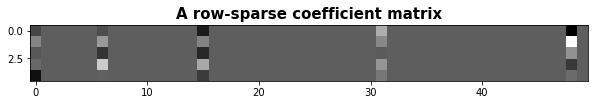

In [31]:
fig = plt.figure(figsize=(10, 7))
plt.title('A row-sparse coefficient matrix', fontweight="bold", fontsize=15)
plt.imshow(coef.T, cmap="binary");

We notice that we have created 5 non-empty rows. We want our model to recover the number of non-zero rows as well as their location. But first, let's compute the max value that $\alpha$ can take. Beyond this threshold, all the coefficients in the coefficient matrix are zero.

In [32]:
def compute_alpha_max(X, Y):
    """ 
    http://proceedings.mlr.press/v84/massias18a/massias18a.pdf
    """
    B = X.T @ Y
    b = np.linalg.norm(B, axis=1)
    return np.max(b) / (X.shape[0] * Y.shape[1])

In [33]:
alpha_max = compute_alpha_max(X, Y)
print('Alpha max:', alpha_max)

Alpha max: 0.045438674877633985


In [34]:
regressor = ReweightedMTL(alpha=0.1)
regressor.fit(X, Y)

Iteration 0: 0.1214
Iteration 1: 0.0608
Iteration 2: 0.0500
Iteration 3: 0.0500
Iteration 4: 0.0500


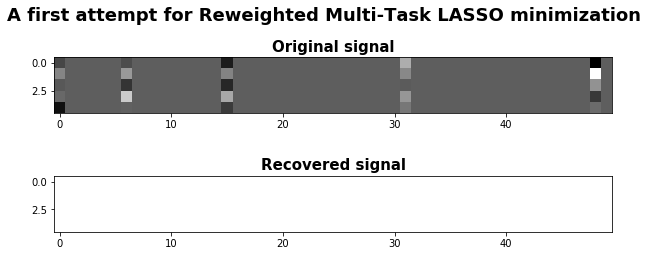

In [35]:
coef_hat = regressor.weights

fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(coef.T, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(coef_hat.T, cmap="binary")

fig.suptitle('A first attempt for Reweighted Multi-Task LASSO minimization', fontweight="bold", fontsize=18);

In order to select the right value for $\alpha$, we will cross-validate the hyperparameter $\alpha$.

## Cross-validation

The cross-validation is done over 5 folds and for $\alpha \in [0.0001,0.04]$.

In [39]:
alphas = np.geomspace(1e-3, 1, num=20)
regressor = MultiTaskLassoCV(alphas, n_folds=5)

In [40]:
regressor.fit(X, Y)

Fitting MTL estimator with alpha = 0.001
Criterion reduced from inf to 0.02127 for alpha = 0.001
Fitting MTL estimator with alpha = 0.0014384498882876629
Criterion reduced from 0.02127 to 0.02126 for alpha = 0.0014384498882876629
Fitting MTL estimator with alpha = 0.00206913808111479
Criterion reduced from 0.02126 to 0.02083 for alpha = 0.00206913808111479
Fitting MTL estimator with alpha = 0.002976351441631319
Fitting MTL estimator with alpha = 0.004281332398719396
Fitting MTL estimator with alpha = 0.006158482110660267
Fitting MTL estimator with alpha = 0.008858667904100823
Criterion reduced from 0.02083 to 0.01915 for alpha = 0.008858667904100823
Fitting MTL estimator with alpha = 0.012742749857031334
Criterion reduced from 0.01915 to 0.01789 for alpha = 0.012742749857031334
Fitting MTL estimator with alpha = 0.018329807108324356
Criterion reduced from 0.01789 to 0.01652 for alpha = 0.018329807108324356
Fitting MTL estimator with alpha = 0.026366508987303583
Criterion reduced from 0

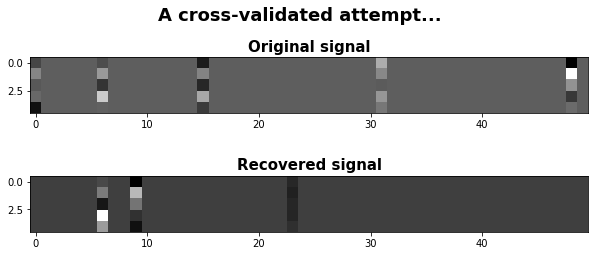

In [41]:
coef_hat = regressor.weights

fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(coef.T, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(coef_hat.T, cmap="binary")

fig.suptitle('A cross-validated attempt...', fontweight="bold", fontsize=18);

We note that 3 out of 5 non zero features are retrieved.
<br/>
Now let's try LASSO on a bigger example and try to find a relation between the support recovery and the number of iterations or $\alpha$.

## A larger example. 

In [17]:
X, Y, W = generate_noisy_data(
    n_samples=50, n_features=250, n_tasks=25, n_relevant_features=25, random_state=2020
)

In [18]:
alpha_max = compute_alpha_max(X, Y)
print('Alpha max:', alpha_max)

Alpha max: 0.0027139232353555103


In [19]:
alphas = np.geomspace(1e-4, 5e-2, num=15)
regressor = MultiTaskLassoCV(alphas, n_folds=3)

In [20]:
regressor.fit(X, Y)

Fitting MTL estimator with alpha = 0.0001


/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011686188234737618, tolerance: 6.693286686407488e-05
  check_random_state(self.random_state), random)
/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.712506420453858e-05, tolerance: 6.991759171561994e-05
  check_random_state(self.random_state), random)


Criterion reduced from inf to 0.00049 for alpha = 0.0001
Fitting MTL estimator with alpha = 0.00015587755020547784
Criterion reduced from 0.00049 to 0.00049 for alpha = 0.00015587755020547784
Fitting MTL estimator with alpha = 0.00024297810658061288
Criterion reduced from 0.00049 to 0.00048 for alpha = 0.00024297810658061288
Fitting MTL estimator with alpha = 0.0003787483200735143
Criterion reduced from 0.00048 to 0.00045 for alpha = 0.0003787483200735143
Fitting MTL estimator with alpha = 0.0005903836027749967
Criterion reduced from 0.00045 to 0.00043 for alpha = 0.0005903836027749967
Fitting MTL estimator with alpha = 0.0009202754968205042
Criterion reduced from 0.00043 to 0.00041 for alpha = 0.0009202754968205042
Fitting MTL estimator with alpha = 0.0014345028995850922
Fitting MTL estimator with alpha = 0.0022360679774997894
Fitting MTL estimator with alpha = 0.003485527984255851
Fitting MTL estimator with alpha = 0.0054331556335843936
Fitting MTL estimator with alpha = 0.0084690699

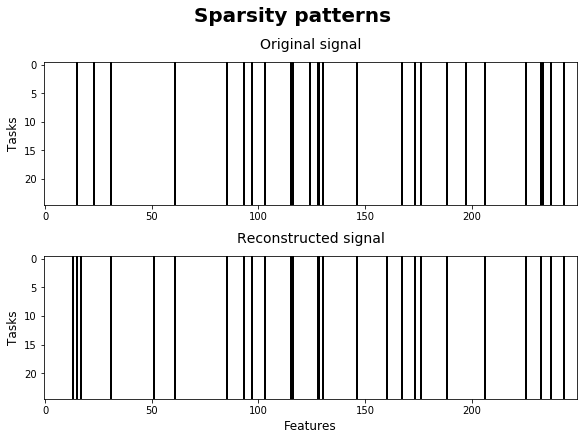

In [21]:
W_hat = regressor.weights

fig, axarr = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)
axarr[0].spy(W.T, aspect="auto")
axarr[0].xaxis.tick_bottom()
axarr[0].set_title("Original signal", fontsize=14)
axarr[0].set_ylabel("Tasks", fontsize=12)
axarr[1].spy(W_hat.T, aspect="auto")
axarr[1].xaxis.tick_bottom()
axarr[1].set_title("Reconstructed signal", fontsize=14)
plt.suptitle("Sparsity patterns", fontweight="bold", fontsize=20)
plt.ylabel("Tasks", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.show(block=False)

It looks quite good. The rows are roughly at the right location and it seems that the expected and the effective number of non-zero rows are equal. Let's check that...

In [22]:
nnz_original = np.count_nonzero(np.count_nonzero(W, axis=1))
nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))

print('Number of non-zero rows in original:', nnz_original)
print('Number of non-zero rows in reconstructed:', nnz_reconstructed)

Number of non-zero rows in original: 25
Number of non-zero rows in reconstructed: 25


Indeed, it is the same!
<br/>
Now let's try to investigate the relationship between the support recovery and the number of iterations. 

## Support recovery and iterations

Let's take the same example as previously. We know that the true support is 25, we want to know how fast the reweighted LASSO converges to this support.

In [23]:
supports = []

In [24]:
for n_iterations in range(1, 11):
    estimator = ReweightedMTL(alpha=0.0009, verbose=False)
    estimator.fit(X, Y, n_iterations=n_iterations)
    
    W_hat = estimator.weights
    nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))
    
    supports.append(nnz_reconstructed)

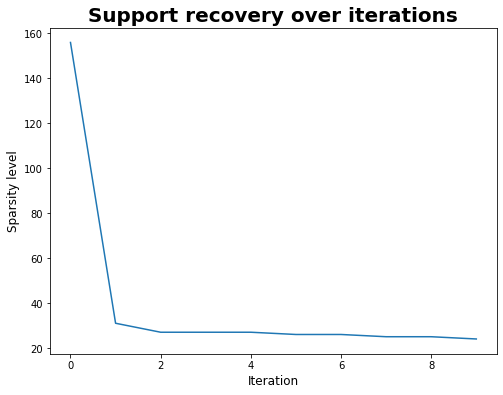

In [25]:
fig = plt.figure(figsize=(8, 6))

plt.plot(supports)
plt.title('Support recovery over iterations', fontweight="bold", fontsize=20)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Sparsity level', fontsize=12);

We see that the model converges very fast in the first iteration and zeroes out the noise quite easily. It takes the whole 10 iterations to come up with the exact number of non-zero coefficients.

## Support recovery and regularizing constant

We will now investigate the relationship between $\alpha$ and the sparsity level. Obviously, we expect that the larger $\alpha$, the larger the sparsity level. Let's verify this intuition.

In [26]:
supports = []

In [27]:
for alpha in alphas:
    estimator = ReweightedMTL(alpha=alpha, verbose=False)
    estimator.fit(X, Y)
    
    W_hat = estimator.weights
    nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))
    
    supports.append(nnz_reconstructed)

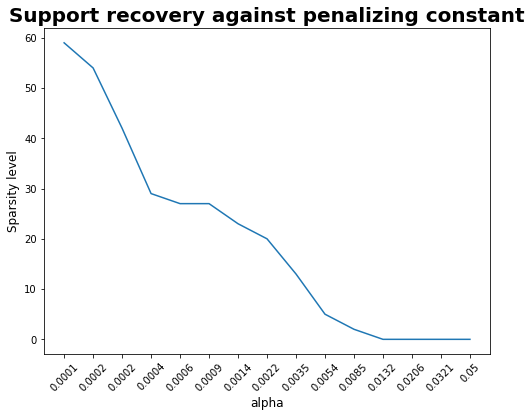

In [28]:
fig = plt.figure(figsize=(8, 6))

xlabels = [str(round(x, 4)) for x in alphas]

plt.plot(supports)
plt.title('Support recovery against penalizing constant', fontweight="bold", fontsize=20)
plt.xlabel('alpha', fontsize=12)
plt.xticks(np.arange(len(alphas)), xlabels)
plt.xticks(rotation=45)
plt.ylabel('Sparsity level', fontsize=12);

Indeed, we find that the larger alpha, the smaller the support and that at around 0.02, the support is empty.